Introduction to the Concept of Inverse Training
Inverse training, also called input reconstruction or backpropagation for inputs, is a process where instead of adjusting the model’s weights to fit the data (as we do in regular training), we fix the weights of a pre-trained model and update the input to match a desired output. This experiment can provide useful insights into how the model encodes information and how much of the input can be reconstructed from the model’s learned representation.

**Key Concept**:

- Forward Training: Adjusts the weights of the model by minimizing the error between the model’s output and the true label for a given input.
Inverse Training: Adjusts the input by minimizing the error between the model's output (given some initial input) and a target output, without updating the weights.
This technique is often used in:

- Deep Dream and Neural Style Transfer: Where the input image is modified to emphasize certain learned features.
Autoencoders: The decoder part reconstructs the input from a latent representation.
- GAN Inversion: Finding the closest latent code in a pre-trained GAN that can generate an image close to a given target.

High-Level Plan

- Train a Model: First, we need a pre-trained model that maps inputs to outputs.
Freeze the Weights: During inverse training, the model's weights will remain constant.
Update the Input: Backpropagate the loss with respect to the input (instead of weights) to minimize the difference between the predicted output and the target output.
Generate Input: After several iterations, you will get an input that matches the given output as closely as possible.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from tqdm import tqdm

Let’s start with a simple neural network trained on the MNIST dataset (handwritten digits). We’ll first train a classifier and then attempt to reconstruct a specific input image (e.g., an image of a digit) from its predicted label using inverse training.

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

train_dataset = datasets.MNIST(root = "./data", train = True, transform = transform,download = True)
train_loader = torch.utils.data.DataLoader(dataset = train_dataset, batch_size = 64, shuffle = True)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 11537021.69it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 352058.82it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 3144343.07it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 7775726.03it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [4]:
class SimpleNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.fc1 = nn.Linear(28*28, 128)
    self.fc2 = nn.Linear(128, 64)
    self.fc3 = nn.Linear(64, 10)

  def forward(self,x):
    x = x.view(-1, 28*28) #768
    x = torch.relu(self.fc1(x))
    x = torch.relu(self.fc2(x))
    x = self.fc3(x)
    return x

model = SimpleNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = 0.01)

epochs = 5
for epoch in range(epochs):
  for images, labels in tqdm(train_loader, desc = 'Training', leave = False):
    optimizer.zero_grad()
    output = model(images)
    loss = criterion(output, labels)
    loss.backward()
    optimizer.step()

- Initialize Input: Instead of using a real input, we initialize a random noise tensor (generated_input).
- Optimizer for Input: We use an optimizer (Adam in this case) to update the input instead of the model weights.
- Freeze Model Weights: We freeze the model weights to ensure they don't change during inverse training.
- Loss Calculation: We compute the loss between the current model output and the target label (here, a one-hot encoded '7').
- Backpropagation for Input: We backpropagate the loss to update the input, allowing the noise tensor to gradually resemble the digit '7'.


In [6]:
target_label = torch.tensor([7])
generated_input = torch.randn(1,28,28,requires_grad = True) #random image
optimizer_input = optim.Adam([generated_input], lr=0.1)

for param in model.parameters():
  param.requires_grad = False

#One hot target label
target_output = torch.nn.functional.one_hot(target_label,num_classes = 10).float()

for step in range(1000):
  optimizer_input.zero_grad()
  output = model(generated_input)

  loss = torch.nn.functional.mse_loss(output, target_output)
  loss.backward()
  optimizer_input.step()

  if step % 100 == 0:
    print(f"Step {step}: Loss {loss.item()}")

Step 0: Loss 1.0789083242416382
Step 100: Loss 2.5836130589595996e-05
Step 200: Loss 5.662671442863143e-10
Step 300: Loss 2.7221975352044805e-14
Step 400: Loss 6.487865800153259e-16
Step 500: Loss 5.814099371490456e-15
Step 600: Loss 1.1953632189447803e-14
Step 700: Loss 1.5508427875232655e-15
Step 800: Loss 7.620987513474488e-15
Step 900: Loss 2.920372412862707e-14


After the optimization, we can visualize the generated_input to see how well the network was able to reconstruct the input for the label '7':

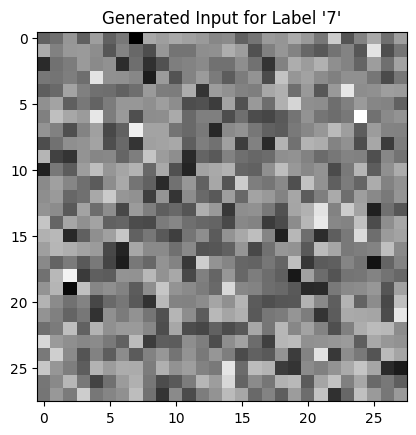

In [7]:
import matplotlib.pyplot as plt

generated_input_np = generated_input.detach().numpy().squeeze() #remove batch

plt.imshow(generated_input_np, cmap = 'gray')
plt.title("Generated Input for Label '7'")
plt.show()

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms

# Load a pre-trained CNN (ResNet18, for example)
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(512, 10)  # Assume we're still working with 10 classes like MNIST

# Freeze model parameters
for param in model.parameters():
    param.requires_grad = False

# Define a target label
target_label = torch.tensor([7])  # Target class, e.g., digit '7'
generated_input = torch.randn(1, 3, 224, 224, requires_grad=True)  # Start with random image

# Optimizer for the input image
optimizer_input = optim.Adam([generated_input], lr=0.1)

# One-hot encode the target output
target_output = torch.nn.functional.one_hot(target_label, num_classes=10).float()

# Add L2 regularization (for smoothness) and use a loop to optimize the input
for step in range(1000):
    optimizer_input.zero_grad()

    # Forward pass: generate output from the current generated input
    output = model(generated_input)

    # Calculate the loss between model output and target output (Cross-Entropy Loss)
    loss = torch.nn.functional.cross_entropy(output, target_label)  # Now using Cross-Entropy instead of MSE

    # Add L2 regularization to keep the input from being too noisy
    l2_reg = torch.norm(generated_input, p=2)
    total_loss = loss + 0.01 * l2_reg  # Adjust the regularization weight as needed

    # Backpropagate the loss to update the input
    total_loss.backward()
    optimizer_input.step()

    # Clip the values of the generated input to ensure they are within the valid range [0, 1]
    with torch.no_grad():
        generated_input.clamp_(0, 1)

    # Print progress
    if step % 100 == 0:
        print(f"Step {step}: Loss {total_loss.item()}")


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 59.8MB/s]


Step 0: Loss 6.072980880737305
Step 100: Loss 2.6478538513183594
Step 200: Loss 2.4342708587646484
Step 300: Loss 2.3009817600250244
Step 400: Loss 2.2543129920959473
Step 500: Loss 2.2585108280181885
Step 600: Loss 2.2227277755737305
Step 700: Loss 2.1358795166015625
Step 800: Loss 2.1794426441192627
Step 900: Loss 2.152759552001953


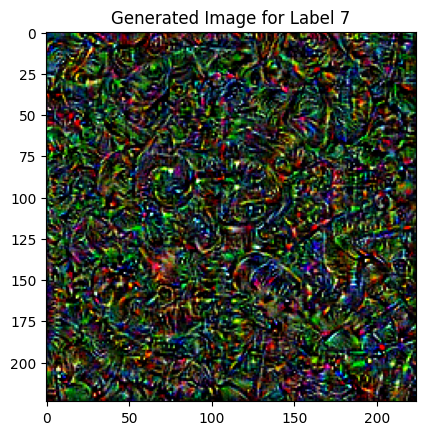

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Detach the tensor and convert it to a NumPy array for visualization
generated_input_np = generated_input.detach().numpy().squeeze().transpose(1, 2, 0)

plt.imshow(generated_input_np)
plt.title(f"Generated Image for Label {target_label.item()}")
plt.show()


**Need further exploration**